In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

Numerical Natural frequencies (Hz):
Mode 1: 40.75 Hz
Mode 2: 163.03 Hz
Mode 3: 366.97 Hz
Mode 4: 653.12 Hz
Mode 5: 1022.83 Hz


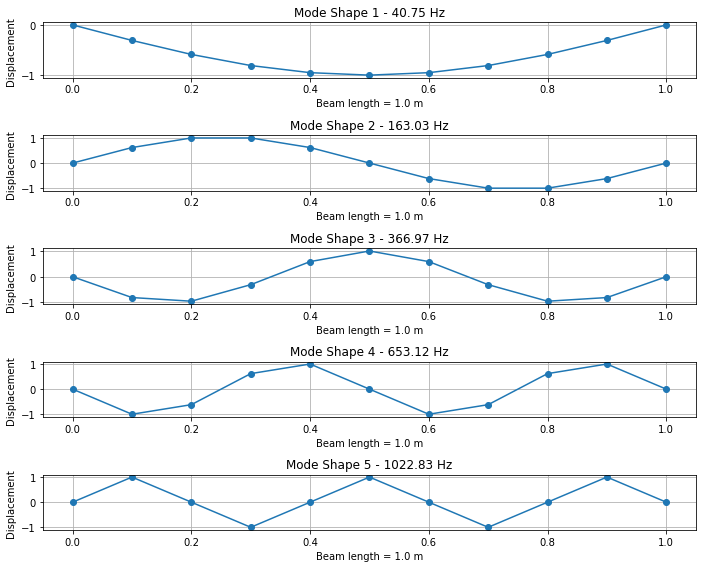

In [2]:
# Beam and material properties
L = 1.0                     # Total beam length [m]
E = 210e9                   # Young's modulus [Pa]
rho = 7800                  # Density [kg/m^3]
D = 0.02                    # Diameter of beam / m
I = (np.pi * D**4) / 64     # Moment of inertia for circular cross-section [m^4]
A = (np.pi * D**2) / 4      # Cross-sectional area [m^2]



   
# === FEM discretization ===
n_elem = 10
n_nodes = n_elem + 1
dof_per_node = 2                        # 2 DOFs: Transverse displacement & angle
total_dof = dof_per_node * n_nodes
dx = L / n_elem                         # Length of one element

# Element stiffness and mass matrices (4x4)
def beam_element_matrices(E, I, rho, A, L):
    # Stiffness matrix
    k = E * I / L**3 * np.array([
        [12, 6*L, -12, 6*L],
        [6*L, 4*L**2, -6*L, 2*L**2],
        [-12, -6*L, 12, -6*L],
        [6*L, 2*L**2, -6*L, 4*L**2]
    ])
    
    # Consistent mass matrix
    m = rho * A * L / 420 * np.array([
        [156, 22*L, 54, -13*L],
        [22*L, 4*L**2, 13*L, -3*L**2],
        [54, 13*L, 156, -22*L],
        [-13*L, -3*L**2, -22*L, 4*L**2]
    ])
    
    return k, m

# Initialize global matrices 
K_global = np.zeros((total_dof, total_dof)) # Creating a 0 Matrix with right size to save elements step by step inside
M_global = np.zeros((total_dof, total_dof))


# Assembly of global matrices
# Explanation in Notes
for e in range(n_elem):
    k_e, m_e = beam_element_matrices(E, I, rho, A, dx)
    dof_map = [2*e, 2*e+1, 2*e+2, 2*e+3]
    
    for i in range(4):
        for j in range(4):
            K_global[dof_map[i], dof_map[j]] += k_e[i, j]
            M_global[dof_map[i], dof_map[j]] += m_e[i, j]
            

# Boundary conditions (Simply supported beam: w=0 at both ends)
# Remove DOFs: displacement DOF at node 0 and node n_nodes-1
constrained_dofs = [0, 2*n_nodes - 2]                               # w at both ends
free_dofs = np.setdiff1d(np.arange(total_dof), constrained_dofs)

# Reduce matrices eliminating the fixed DOF 
K_reduced = K_global[np.ix_(free_dofs, free_dofs)]
M_reduced = M_global[np.ix_(free_dofs, free_dofs)]

# Solve eigenvalue problem
eigvals, eigvecs = eigh(K_reduced, M_reduced)

#                    Filter small/negative eigenvalues (numerical noise)
#                    eigvals = eigvals[eigvals > 1e-8]
numerical_freqs = np.sqrt(eigvals) / (2 * np.pi)






# Print first natural frequencies
print("Numerical Natural frequencies (Hz):")
for i, f in enumerate(numerical_freqs[:5]):
    print(f"Mode {i+1}: {f:.2f} Hz")
    
    
    
# Plot mode shapes (displacement part only)
x = np.linspace(0, L, n_nodes)
n_modes = min(5, len(numerical_freqs))            # Change number of mode shapes to plot here

plt.figure(figsize=(10, 8))
for i in range(n_modes):
    # Reconstruct full mode shape including constrained DOFs
    full_mode = np.zeros(total_dof)
    full_mode[free_dofs] = eigvecs[:, i]

    w_only = full_mode[::2]  # Take displacement DOFs only
    w_only /= np.max(np.abs(w_only))  # Normalize

    plt.subplot(n_modes, 1, i+1)
    plt.plot(x, w_only, '-o')
    plt.title(f"Mode Shape {i+1} - {numerical_freqs[i]:.2f} Hz")
    plt.xlabel(f"Beam length = {L} m")
    plt.ylabel("Displacement ")
    plt.grid(True)

plt.tight_layout()
plt.show()



Analytical Natural Frequencies (Hz):
Mode 1: 40.75 Hz
Mode 2: 163.01 Hz
Mode 3: 366.77 Hz
Mode 4: 652.04 Hz
Mode 5: 1018.81 Hz


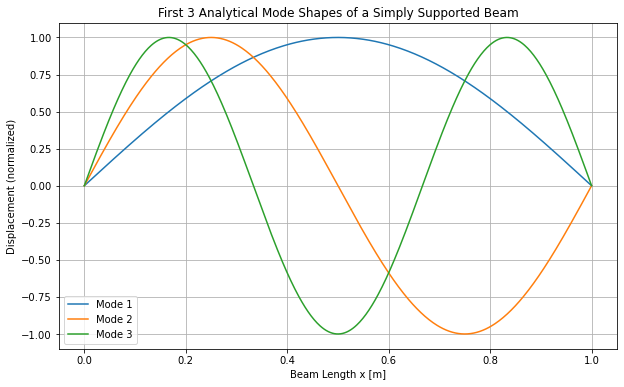

In [3]:
# === ANALYTICAL SOLUTION for Simply Supported Beam ===
def beta_n(n, L):
    return n * np.pi / L

def omega_n(n, E, I, rho, A, L):
    beta = beta_n(n, L)
    return beta**2 * np.sqrt(E * I / (rho * A))

def mode_shape(n, x, L):
    return np.sin(beta_n(n, L) * x)

# === Calculate Natural Frequencies and Mode Shapes ===
n_modes = 5
x_vals = np.linspace(0, L, 500)

analytical_freqs = []
analytical_shapes = []

for n in range(1, n_modes + 1):
    omega = omega_n(n, E, I, rho, A, L)
    f = omega / (2 * np.pi)
    analytical_freqs.append(f)
    if n <= 3:  # Only plot first 3 mode shapes
        shape = mode_shape(n, x_vals, L)
        analytical_shapes.append(shape)

# === OUTPUT ===
print("\nAnalytical Natural Frequencies (Hz):")
for i, f in enumerate(analytical_freqs):
    print(f"Mode {i+1}: {f:.2f} Hz")

# === PLOT First 3 Analytical Mode Shapes ===
plt.figure(figsize=(10, 6))
for i, shape in enumerate(analytical_shapes):
    plt.plot(x_vals, shape, label=f"Mode {i+1}")
plt.title("First 3 Analytical Mode Shapes of a Simply Supported Beam")
plt.xlabel("Beam Length x [m]")
plt.ylabel("Displacement (normalized)")
plt.grid(True)
plt.legend()
plt.show()

In [4]:
# === COMPARISON WITH NUMERICAL FREQUENCIES ===
print("\nComparison of Analytical vs Numerical Natural Frequencies:")
print(f"{'Mode':<5} {'Analytical (Hz)':<20} {'Numerical (Hz)':<20} {'Error (%)':<10}")
for i in range(n_modes):
    ana = analytical_freqs[i]
    num = numerical_freqs[i]
    error = abs((num - ana) / ana) * 100
    print(f"{i+1:<5} {ana:<20.2f} {num:<20.2f} {error:<10.2f}")


Comparison of Analytical vs Numerical Natural Frequencies:
Mode  Analytical (Hz)      Numerical (Hz)       Error (%) 
1     40.75                40.75                0.00      
2     163.01               163.03               0.01      
3     366.77               366.97               0.05      
4     652.04               653.12               0.17      
5     1018.81              1022.83              0.39      


# 3D

Numerical Natural frequencies (Hz):
Mode 1: 40.75 Hz
Mode 2: 40.75 Hz
Mode 3: 163.03 Hz
Mode 4: 163.03 Hz
Mode 5: 366.97 Hz


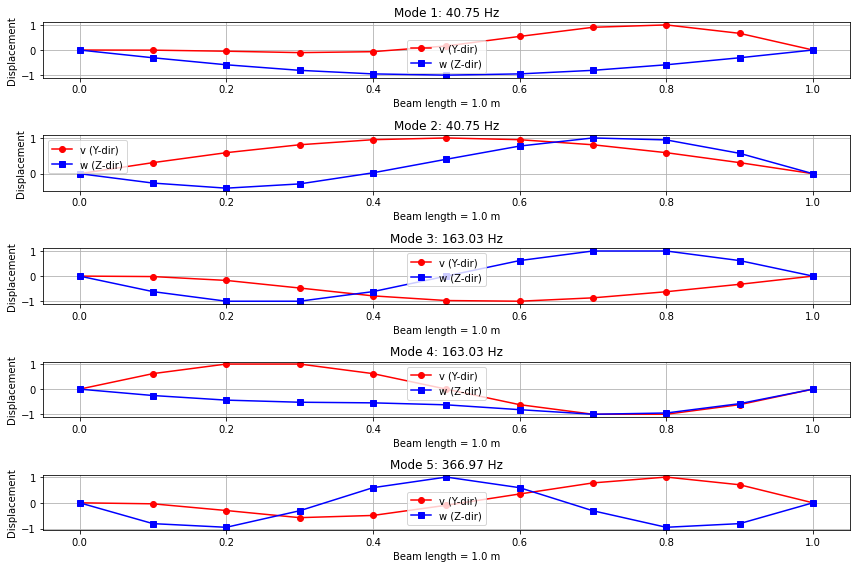

In [5]:
# Beam and material properties
L = 1.0                     # Total beam length [m]
E = 210e9                   # Young's modulus [Pa]
rho = 7800                  # Density [kg/m^3]
D = 0.02                    # Diameter of beam / m
I = (np.pi * D**4) / 64     # Moment of inertia for circular cross-section [m^4]
A = (np.pi * D**2) / 4      # Cross-sectional area [m^2]



# FEM discretization
n_elem = 10
n_nodes = n_elem + 1
dof_per_node = 4     #translation and rotation in Z and Y
total_dof = dof_per_node * n_nodes
dx = L / n_elem

# === 3D Beam Element Matrices (Bending in Y and Z) ===
def beam_3d_bending_matrices(E, I, rho, A, L):
    # 8x8 matrix = 4 DOFs per node × 2 nodes
    # Assume uncoupled bending in Y (v-θz) and Z (w-θy)
    
    # 2D bending stiffness matrix for one plane
    k2d = E * I / L**3 * np.array([
        [12,     6*L,    -12,    6*L],
        [6*L,  4*L**2, -6*L,  2*L**2],
        [-12,   -6*L,     12,   -6*L],
        [6*L,  2*L**2, -6*L,  4*L**2]
    ])
    
    # 2D consistent mass matrix
    m2d = rho * A * L / 420 * np.array([
        [156,     22*L,     54,    -13*L],
        [22*L,  4*L**2,  13*L,  -3*L**2],
        [54,      13*L,    156,   -22*L],
        [-13*L, -3*L**2, -22*L,  4*L**2]
    ])
    
    # Create 8x8 block diagonal matrix
    k = np.zeros((8, 8))
    m = np.zeros((8, 8))
    
    # Fill v-θz (DOFs 0–3 and 4–7)
    k[np.ix_([0,1,4,5],[0,1,4,5])] = k2d
    m[np.ix_([0,1,4,5],[0,1,4,5])] = m2d
    
    # Fill w-θy (DOFs 2–3 and 6–7)
    k[np.ix_([2,3,6,7],[2,3,6,7])] = k2d
    m[np.ix_([2,3,6,7],[2,3,6,7])] = m2d
    
    return k, m

# === Global Matrix Assembly ===
K_global = np.zeros((total_dof, total_dof))
M_global = np.zeros((total_dof, total_dof))

for e in range(n_elem):
    k_e, m_e = beam_3d_bending_matrices(E, I, rho, A, dx)
    dof_map = [4*e + i for i in range(8)]
    
    for i in range(8):
        for j in range(8):
            K_global[dof_map[i], dof_map[j]] += k_e[i, j]
            M_global[dof_map[i], dof_map[j]] += m_e[i, j]

# === Boundary Conditions ===
# Fix both ends: v and w (transverse displacements)
constrained_dofs = [0, 2, total_dof - 4, total_dof - 2]  # v0, w0, vN, wN
free_dofs = np.setdiff1d(np.arange(total_dof), constrained_dofs)

K_reduced = K_global[np.ix_(free_dofs, free_dofs)]
M_reduced = M_global[np.ix_(free_dofs, free_dofs)]

# === Solve Eigenvalue Problem ===
eigvals, eigvecs = eigh(K_reduced, M_reduced)
frequencies = np.sqrt(eigvals) / (2 * np.pi)  #numerical_freqs




# Print first natural frequencies
print("Numerical Natural frequencies (Hz):")
for i, f in enumerate(frequencies[:5]):
    print(f"Mode {i+1}: {f:.2f} Hz")
    
    
    
# === Plot First Mode Shapes in 3D ===
n_modes = 5    # Change number of mode shapes to plot here
# n_modes = min(5, len(frequencies))
x = np.linspace(0, L, n_nodes)

fig = plt.figure(figsize=(12, 8))
for i in range(n_modes):
# Reconstruct full mode shape including constrained DOFs
    full_mode = np.zeros(total_dof)
    full_mode[free_dofs] = eigvecs[:, i]
                      
    v = full_mode[0::4]
    w = full_mode[2::4]
    v /= np.max(np.abs(v))
    w /= np.max(np.abs(w))
    
    ax = fig.add_subplot(n_modes, 1, i+1)
    plt.plot(x, v, 'r-o', label='v (Y-dir)')
    plt.plot(x, w, 'b-s', label='w (Z-dir)')
    plt.title(f"Mode {i+1}: {frequencies[i]:.2f} Hz")
    plt.xlabel(f"Beam length = {L} m")
    plt.ylabel("Displacement")
    plt.legend()
    plt.grid(True)


plt.tight_layout()
plt.show()

# Corrected 3D

Natural frequencies (Y plane):
w_y_1: 40.75 Hz
w_y_2: 163.03 Hz
w_y_3: 366.97 Hz
w_y_4: 653.12 Hz
w_y_5: 1022.83 Hz
w_y_6: 1478.73 Hz

Natural frequencies (Z plane):
w_z_1: 40.75 Hz
w_z_2: 163.03 Hz
w_z_3: 366.97 Hz
w_z_4: 653.12 Hz
w_z_5: 1022.83 Hz
w_z_6: 1478.73 Hz


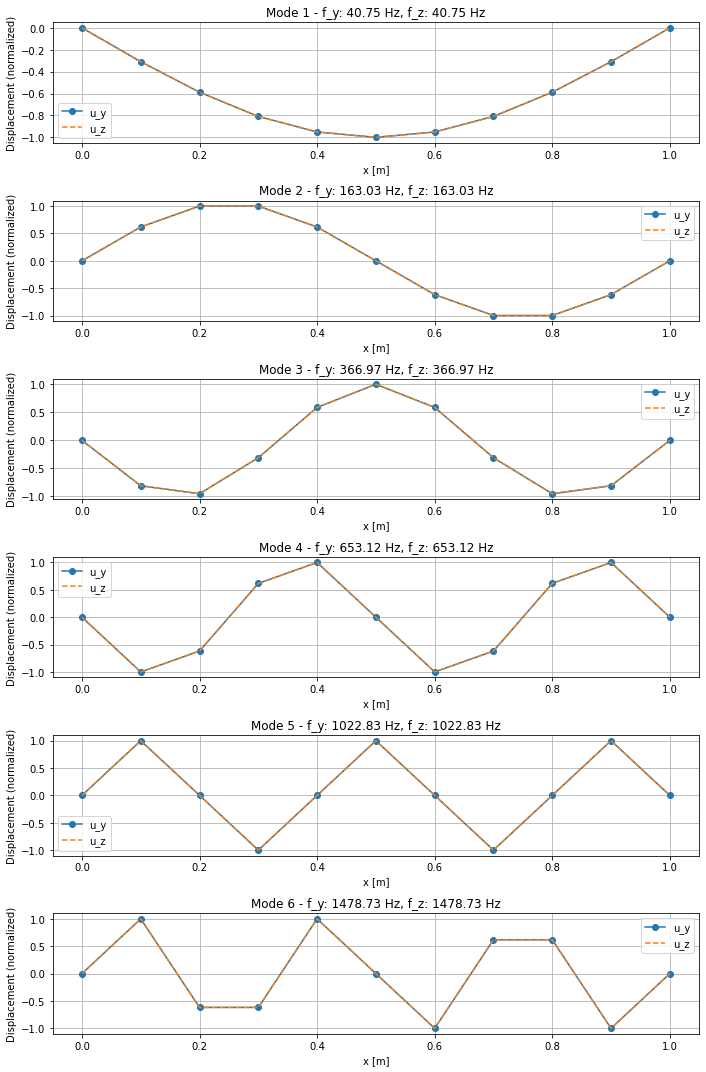

In [14]:
# Beam and material properties
L = 1.0                     # Total beam length [m]
E = 210e9                   # Young's modulus [Pa]
rho = 7800                  # Density [kg/m^3]
D = 0.02                    # Diameter of beam [m]
I = (np.pi * D**4) / 64     # Moment of inertia [m^4]
A = (np.pi * D**2) / 4      # Cross-sectional area [m^2]

# === FEM discretization ===
n_elem = 10
n_nodes = n_elem + 1
dof_per_node = 2  # per plane: [u, theta]
total_dof = dof_per_node * n_nodes
dx = L / n_elem

# === Element stiffness and mass matrices (4x4 for each plane) ===
def beam_element_matrices(E, I, rho, A, L):
    K_local = (E * I / L**3) * np.array([
        [12, 6*L, -12, 6*L],
        [6*L, 4*L**2, -6*L, 2*L**2],
        [-12, -6*L, 12, -6*L],
        [6*L, 2*L**2, -6*L, 4*L**2]
    ])
    
    M_local = (rho * A * L / 420) * np.array([
        [156, 22*L, 54, -13*L],
        [22*L, 4*L**2, 13*L, -3*L**2],
        [54, 13*L, 156, -22*L],
        [-13*L, -3*L**2, -22*L, 4*L**2]
    ])
    
    return K_local, M_local

# === Initialize global matrices for Y and Z planes ===
K_global_y = np.zeros((total_dof, total_dof))
M_global_y = np.zeros((total_dof, total_dof))

K_global_z = np.zeros((total_dof, total_dof))
M_global_z = np.zeros((total_dof, total_dof))

# === Assembly ===
K_local, M_local = beam_element_matrices(E, I, rho, A, dx)

for e in range(n_elem):
    dof_map = [2*e, 2*e+1, 2*e+2, 2*e+3]
    
    for i in range(4):
        for j in range(4):
            K_global_y[dof_map[i], dof_map[j]] += K_local[i, j]
            M_global_y[dof_map[i], dof_map[j]] += M_local[i, j]
            K_global_z[dof_map[i], dof_map[j]] += K_local[i, j]
            M_global_z[dof_map[i], dof_map[j]] += M_local[i, j]

# === Boundary conditions (simply supported at both ends) ===
# Fix displacement DOF at node 0 and last node
constrained_dofs = [0, dof_per_node*(n_nodes-1)]

free_dofs = np.setdiff1d(np.arange(total_dof), constrained_dofs)

# === Reduce matrices ===
K_reduced_y = K_global_y[np.ix_(free_dofs, free_dofs)]
M_reduced_y = M_global_y[np.ix_(free_dofs, free_dofs)]

K_reduced_z = K_global_z[np.ix_(free_dofs, free_dofs)]
M_reduced_z = M_global_z[np.ix_(free_dofs, free_dofs)]

# === Solve eigenvalue problem for Y and Z planes ===
eigvals_y, eigvecs_y = eigh(K_reduced_y, M_reduced_y)
eigvals_z, eigvecs_z = eigh(K_reduced_z, M_reduced_z)

freqs_y = np.sqrt(eigvals_y) / (2 * np.pi)
freqs_z = np.sqrt(eigvals_z) / (2 * np.pi)

# === Print frequencies ===
print("Natural frequencies (Y plane):")
for i, f in enumerate(freqs_y[:6]):
    print(f"w_y_{i+1}: {f:.2f} Hz")

print("\nNatural frequencies (Z plane):")
for i, f in enumerate(freqs_z[:6]):
    print(f"w_z_{i+1}: {f:.2f} Hz")

# === Plot mode shapes ===
x = np.linspace(0, L, n_nodes)
n_modes = min(6, len(freqs_y))

plt.figure(figsize=(10, 2.5 * n_modes))

for i in range(n_modes):
    # reconstruct full mode shape
    mode_y = np.zeros(total_dof)
    mode_z = np.zeros(total_dof)
    mode_y[free_dofs] = eigvecs_y[:, i]
    mode_z[free_dofs] = eigvecs_z[:, i]
    
    w_y = mode_y[::dof_per_node]
    w_z = mode_z[::dof_per_node]
    
    w_y /= np.max(np.abs(w_y))
    w_z /= np.max(np.abs(w_z))
    
    plt.subplot(n_modes, 1, i+1)
    plt.plot(x, w_y, '-o', label='u_y')
    plt.plot(x, w_z, '--', label='u_z')
    plt.title(f"Mode {i+1} - f_y: {freqs_y[i]:.2f} Hz, f_z: {freqs_z[i]:.2f} Hz")
    plt.xlabel("x [m]")
    plt.ylabel("Displacement (normalized)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()



Analytical Natural Frequencies (Hz):
Mode 1: 40.75 Hz
Mode 2: 163.01 Hz
Mode 3: 366.77 Hz
Mode 4: 652.04 Hz
Mode 5: 1018.81 Hz


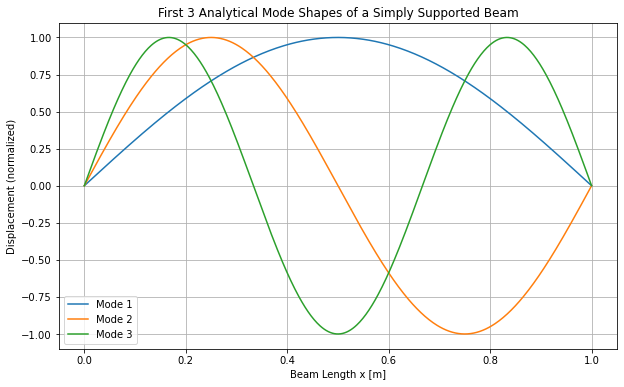

In [6]:
# === ANALYTICAL SOLUTION for Simply Supported 3D Beam (Y and Z planes are identical) ===
def beta_n(n, L):
    return n * np.pi / L

def omega_n(n, E, I, rho, A, L):
    beta = beta_n(n, L)
    return beta**2 * np.sqrt(E * I / (rho * A))

def mode_shape(n, x, L):
    return np.sin(beta_n(n, L) * x)

# === Calculate Analytical Frequencies and Mode Shapes ===
n_modes = 5
x_vals = np.linspace(0, L, 500)

analytical_freqs = []
analytical_shapes = []

for n in range(1, n_modes + 1):
    omega = omega_n(n, E, I, rho, A, L)
    f = omega / (2 * np.pi)
    analytical_freqs.append(f)
    if n <= 3:  # Only plot first 3 mode shapes
        shape = mode_shape(n, x_vals, L)
        analytical_shapes.append(shape)

        
# === OUTPUT ===
print("\nAnalytical Natural Frequencies (Hz):")
for i, f in enumerate(analytical_freqs):
    print(f"Mode {i+1}: {f:.2f} Hz")

# === PLOT First 3 Analytical Mode Shapes ===
plt.figure(figsize=(10, 6))
for i, shape in enumerate(analytical_shapes):
    plt.plot(x_vals, shape, label=f"Mode {i+1}")
plt.title("First 3 Analytical Mode Shapes of a Simply Supported Beam")
plt.xlabel("Beam Length x [m]")
plt.ylabel("Displacement (normalized)")
plt.grid(True)
plt.legend()
plt.show()

In [7]:
# === COMPARISON WITH NUMERICAL FREQUENCIES ===
print("\nComparison of Analytical vs Numerical Natural Frequencies (Y/Z bending):")
print(f"{'Mode':<5} {'Analytical (Hz)':<20} {'Numerical (Hz)':<20} {'Error (%)':<10}")
for i in range(n_modes):
    ana = analytical_freqs[i]
    num = frequencies[i]
    error = abs((num - ana) / ana) * 100
    print(f"{i+1:<5} {ana:<20.2f} {num:<20.2f} {error:<10.2f}")



Comparison of Analytical vs Numerical Natural Frequencies (Y/Z bending):
Mode  Analytical (Hz)      Numerical (Hz)       Error (%) 
1     40.75                40.75                0.00      
2     163.01               40.75                75.00     
3     366.77               163.03               55.55     
4     652.04               163.03               75.00     
5     1018.81              366.97               63.98     



Corrected Comparison of Analytical vs Numerical Natural Frequencies (Y/Z bending):
Mode  Analytical (Hz)      Numerical (Hz)       Error (%) 
1     40.75                40.75                0.00      
2     163.01               163.03               0.01      
3     366.77               366.97               0.05      
4     652.04               653.12               0.17      
5     1018.81              1022.83              0.39      


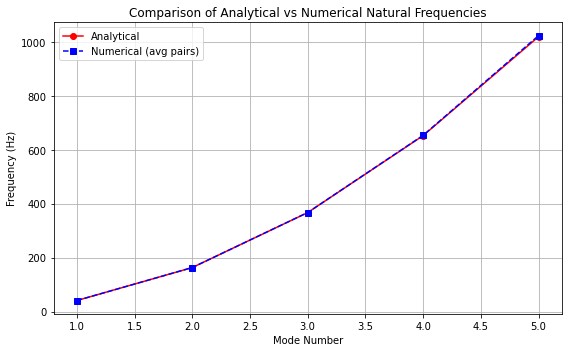

In [13]:
# === Corrected Comparison: Group Numerical Modes by Pairs ===
paired_freqs = 0.5 * (frequencies[::2] + frequencies[1::2])  # Average every pair
n_modes_comp = min(len(paired_freqs), len(analytical_freqs))

# === Print Comparison Table ===
print("\nCorrected Comparison of Analytical vs Numerical Natural Frequencies (Y/Z bending):")
print(f"{'Mode':<5} {'Analytical (Hz)':<20} {'Numerical (Hz)':<20} {'Error (%)':<10}")
for i in range(n_modes_comp):
    ana = analytical_freqs[i]
    num = paired_freqs[i]
    error = abs((num - ana) / ana) * 100
    print(f"{i+1:<5} {ana:<20.2f} {num:<20.2f} {error:<10.2f}")

# === Optional: Plot Comparison ===
plt.figure(figsize=(8, 5))
modes = np.arange(1, n_modes_comp + 1)
plt.plot(modes, analytical_freqs[:n_modes_comp], 'ro-', label='Analytical')
plt.plot(modes, paired_freqs[:n_modes_comp], 'bs--', label='Numerical (avg pairs)')
plt.title("Comparison of Analytical vs Numerical Natural Frequencies")
plt.xlabel("Mode Number")
plt.ylabel("Frequency (Hz)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 2D Bearing/rigid disc

# Add a bearing:
That includes:

    Position along the beam (user-defined)

    Bearing diameter (influencing stiffness)

    Flexible stiffness

    A rigid disc at that location

Effects like:

    Added mass

    Added rotational inertia (to global mass matrix)

    Everything should be parameterized so you can change by hand
    
# Implementation Plan
We'll:

    Ask the user to define bearing parameters

Compute:

    Translational spring stiffness of the bearing
    
    Mass and moment of inertia of the disc

Apply:

    Add point mass and inertia to global mass matrix

    Add spring stiffness to global stiffness matrix

Numerical Natural frequencies (Hz):
Mode 1: 126.44 Hz
Mode 2: 165.22 Hz
Mode 3: 353.27 Hz
Mode 4: 651.58 Hz
Mode 5: 947.42 Hz


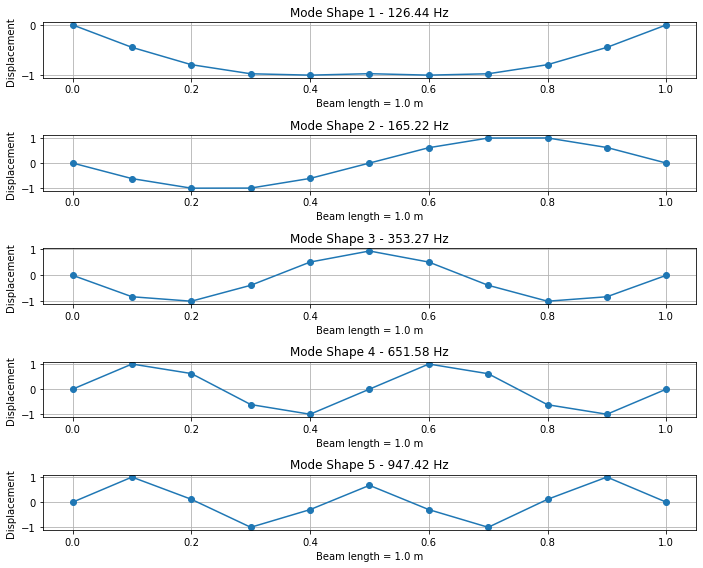

In [16]:
# Beam and material properties
L = 1.0                     # Total beam length [m]
E = 210e9                   # Young's modulus [Pa]
rho = 7800                  # Density [kg/m^3]
D = 0.02                    # Diameter of beam / m
I = (np.pi * D**4) / 64     # Moment of inertia for circular cross-section [m^4]
A = (np.pi * D**2) / 4      # Cross-sectional area [m^2]




# === FEM discretization ===
n_elem = 10
n_nodes = n_elem + 1
dof_per_node = 2                        # 2 DOFs: Transverse displacement & angle
total_dof = dof_per_node * n_nodes
dx = L / n_elem                         # Length of one element

# Element stiffness and mass matrices (4x4)
def beam_element_matrices(E, I, rho, A, L):
    # Stiffness matrix
    k = E * I / L**3 * np.array([
        [12, 6*L, -12, 6*L],
        [6*L, 4*L**2, -6*L, 2*L**2],
        [-12, -6*L, 12, -6*L],
        [6*L, 2*L**2, -6*L, 4*L**2]
    ])
    
    # Consistent mass matrix
    m = rho * A * L / 420 * np.array([
        [156, 22*L, 54, -13*L],
        [22*L, 4*L**2, 13*L, -3*L**2],
        [54, 13*L, 156, -22*L],
        [-13*L, -3*L**2, -22*L, 4*L**2]
    ])
    
    return k, m

# Initialize global matrices 
K_global = np.zeros((total_dof, total_dof)) # Creating a 0 Matrix with right size to save elements step by step inside
M_global = np.zeros((total_dof, total_dof))

# Assembly of global matrices
# Explanation in Notes
for e in range(n_elem):
    k_e, m_e = beam_element_matrices(E, I, rho, A, dx)
    dof_map = [2*e, 2*e+1, 2*e+2, 2*e+3]
    
    for i in range(4):
        for j in range(4):
            K_global[dof_map[i], dof_map[j]] += k_e[i, j]
            M_global[dof_map[i], dof_map[j]] += m_e[i, j]

            
            
            
            
# ========================================================================== USER INPUT FOR BEARING ===
bearing_pos_m = 0.5          # [m] position along beam
bearing_diameter = 0.05      # [m] diameter of rigid disc
disc_thickness = 0.02        # [m] axial thickness
disc_density = 7800          # [kg/m³] (same as beam material)
bearing_k = 1e6              # [N/m] translational stiffness (flexibility of the bearing)
bearing_kr = 1e3             # [Nm/rad] rotational stiffness of bearing (optional)

#bearing_pos_m = 0.5        # middle of beam
#bearing_diameter = 0.05
#bearing_k = 1e5            # softer bearing
#disc_thickness = 0.01


# === DERIVED BEARING PARAMETERS ===
bearing_node = int(round(bearing_pos_m / dx))   # nearest node index
disc_radius = bearing_diameter / 2
disc_volume = np.pi * disc_radius**2 * disc_thickness
disc_mass = disc_volume * disc_density
disc_I_rot = 0.5 * disc_mass * disc_radius**2     # Moment of inertia of disc

# === ADD POINT MASS TO GLOBAL MASS MATRIX ===
bearing_dof_disp = 2 * bearing_node     # displacement DOF
bearing_dof_rot  = 2 * bearing_node + 1 # rotation DOF

M_global[bearing_dof_disp, bearing_dof_disp] += disc_mass
M_global[bearing_dof_rot, bearing_dof_rot]   += disc_I_rot

# === ADD SPRING STIFFNESS (if flexible bearing) ===
K_global[bearing_dof_disp, bearing_dof_disp] += bearing_k
K_global[bearing_dof_rot, bearing_dof_rot]   += bearing_kr   # Optional: for rotation

# =======================================================================================================



# Boundary conditions (Simply supported beam: w=0 at both ends)
# Remove DOFs: displacement DOF at node 0 and node n_nodes-1
constrained_dofs = [0, 2*n_nodes - 2]                               # w at both ends
free_dofs = np.setdiff1d(np.arange(total_dof), constrained_dofs)

# Reduce matrices eliminating the fixed DOF 
K_reduced = K_global[np.ix_(free_dofs, free_dofs)]
M_reduced = M_global[np.ix_(free_dofs, free_dofs)]

# Solve eigenvalue problem
eigvals, eigvecs = eigh(K_reduced, M_reduced)

#                    Filter small/negative eigenvalues (numerical noise)
#                    eigvals = eigvals[eigvals > 1e-8]
numerical_freqs = np.sqrt(eigvals) / (2 * np.pi)

# Print first natural frequencies
print("Numerical Natural frequencies (Hz):")
for i, f in enumerate(numerical_freqs[:5]):
    print(f"Mode {i+1}: {f:.2f} Hz")
    
    
# Plot mode shapes (displacement part only)
x = np.linspace(0, L, n_nodes)
n_modes = min(5, len(numerical_freqs))            # Change number of mode shapes to plot here

plt.figure(figsize=(10, 8))
for i in range(n_modes):
    # Reconstruct full mode shape including constrained DOFs
    full_mode = np.zeros(total_dof)
    full_mode[free_dofs] = eigvecs[:, i]

    w_only = full_mode[::2]  # Take displacement DOFs only
    w_only /= np.max(np.abs(w_only))  # Normalize

    plt.subplot(n_modes, 1, i+1)
    plt.plot(x, w_only, '-o')
    plt.title(f"Mode Shape {i+1} - {numerical_freqs[i]:.2f} Hz")
    plt.xlabel(f"Beam length = {L} m")
    plt.ylabel("Displacement ")
    plt.grid(True)

plt.tight_layout()
plt.show()


# 2D 2 rigid discs 


=== Define the beam and material properties ===
Total beam length [m]: 1
Young's modulus [Pa]: 210e9
Density [kg/m^3]: 7800
Diameter of beam [m]: 0.02
Moment of inertia for circular cross-section [m^4]: 7.853981633974483e-09
Cross-sectional area [m^2]: 0.0003141592653589793

=== Define 2 Rigid Discs ===
Disc 1 position [m]: 0
Disc 1 diameter [m]: 0.05
Disc 1 thickness [m]: 0.02
Disc 1 density [kg/m^3]: 7800
Disc 2 position [m]: 1
Disc 2 diameter [m]: 0.05
Disc 2 thickness [m]: 0.02
Disc 2 density [kg/m^3]: 7800

=== Define 2 Bearings ===
Bearing 1 position [m]: 0
Bearing 1 translational stiffness [N/m]: 1e5
Bearing 1 rotational stiffness [Nm/rad]: 10
Bearing 2 position [m]: 1
Bearing 2 translational stiffness [N/m]: 1e5
Bearing 2 rotational stiffness [Nm/rad]: 10
Numerical Natural frequencies (Hz):
Mode 1: 40.77 Hz
Mode 2: 162.57 Hz
Mode 3: 364.46 Hz
Mode 4: 644.93 Hz
Mode 5: 1002.08 Hz


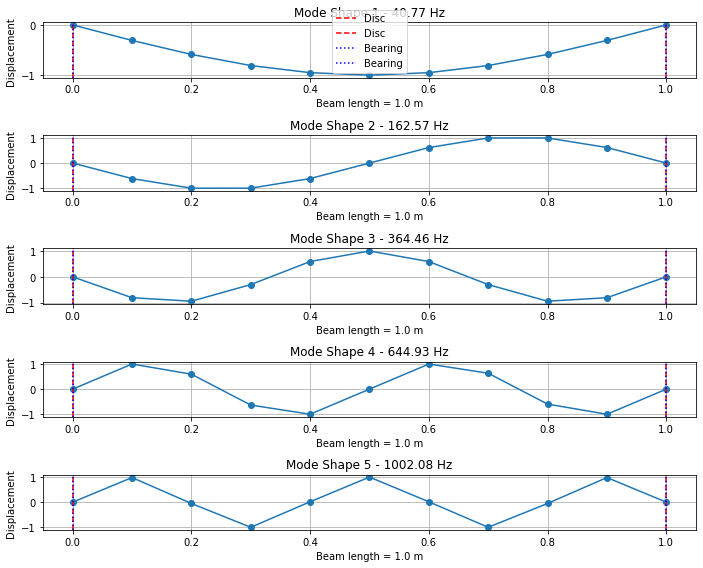

In [40]:
# === USER INPUT FOR BEAM AND MATERIAL PROPERTIES ===
print("\n=== Define the beam and material properties ===")
L = float(input("Total beam length [m]: "))
E = float(input("Young's modulus [Pa]: "))
rho = float(input("Density [kg/m^3]: "))
D  = float(input("Diameter of beam [m]: "))
I = float(input("Moment of inertia for circular cross-section [m^4]: "))
A = float(input("Cross-sectional area [m^2]: "))



# === FEM discretization ===
n_elem = 10
n_nodes = n_elem + 1
dof_per_node = 2                        # 2 DOFs: Transverse displacement & angle
total_dof = dof_per_node * n_nodes
dx = L / n_elem                         # Length of one element

# Element stiffness and mass matrices (4x4)
def beam_element_matrices(E, I, rho, A, L):
    # Stiffness matrix
    k = E * I / L**3 * np.array([
        [12, 6*L, -12, 6*L],
        [6*L, 4*L**2, -6*L, 2*L**2],
        [-12, -6*L, 12, -6*L],
        [6*L, 2*L**2, -6*L, 4*L**2]
    ])
    
    # Consistent mass matrix
    m = rho * A * L / 420 * np.array([
        [156, 22*L, 54, -13*L],
        [22*L, 4*L**2, 13*L, -3*L**2],
        [54, 13*L, 156, -22*L],
        [-13*L, -3*L**2, -22*L, 4*L**2]
    ])
    
    return k, m

# Initialize global matrices 
K_global = np.zeros((total_dof, total_dof)) # Creating a 0 Matrix with right size to save elements step by step inside
M_global = np.zeros((total_dof, total_dof))

# Assembly of global matrices
# Explanation in Notes
for e in range(n_elem):
    k_e, m_e = beam_element_matrices(E, I, rho, A, dx)
    dof_map = [2*e, 2*e+1, 2*e+2, 2*e+3]
    
    for i in range(4):
        for j in range(4):
            K_global[dof_map[i], dof_map[j]] += k_e[i, j]
            M_global[dof_map[i], dof_map[j]] += m_e[i, j]

            
#========================================================================================================================            
# === USER INPUT FOR 2 DISCS ===
print("\n=== Define 2 Rigid Discs ===")
disc1_pos = float(input("Disc 1 position [m]: "))   # [m] position along beam
disc1_diam = float(input("Disc 1 diameter [m]: "))   # [m] diameter of rigid disc
disc1_thick = float(input("Disc 1 thickness [m]: "))   # [m] axial thickness
disc1_density = float(input("Disc 1 density [kg/m^3]: "))   # [kg/m³] (same as beam material)

disc2_pos = float(input("Disc 2 position [m]: "))
disc2_diam = float(input("Disc 2 diameter [m]: "))
disc2_thick = float(input("Disc 2 thickness [m]: "))
disc2_density = float(input("Disc 2 density [kg/m^3]: "))

  
# === USER INPUT FOR FLEXIBLE BEARINGS ===
print("\n=== Define 2 Bearings ===")
bear1_pos = float(input("Bearing 1 position [m]: "))   # [m] position along beam
bear1_k = float(input("Bearing 1 translational stiffness [N/m]: ")) # [N/m] translational stiffness (flexibility of the bearing)
bear1_kr = float(input("Bearing 1 rotational stiffness [Nm/rad]: ")) # [Nm/rad] rotational stiffness of bearing (optional)

bear2_pos = float(input("Bearing 2 position [m]: "))
bear2_k = float(input("Bearing 2 translational stiffness [N/m]: "))
bear2_kr = float(input("Bearing 2 rotational stiffness [Nm/rad]: "))




# === Apply Discs ===
for pos, diam, thick, dens in [(disc1_pos, disc1_diam, disc1_thick, disc1_density),
                                (disc2_pos, disc2_diam, disc2_thick, disc2_density)]:
    node = int(round(pos / dx))
    radius = diam / 2
    volume = np.pi * radius**2 * thick
    mass = volume * dens
    I_rot = 0.5 * mass * radius**2

    dof_disp = 2 * node
    dof_rot  = 2 * node + 1

    M_global[dof_disp, dof_disp] += mass
    M_global[dof_rot, dof_rot]   += I_rot

# === Apply Bearings ===
for pos, k, kr in [(bear1_pos, bear1_k, bear1_kr),
                   (bear2_pos, bear2_k, bear2_kr)]:
    node = int(round(pos / dx))
    dof_disp = 2 * node
    dof_rot  = 2 * node + 1

    K_global[dof_disp, dof_disp] += k
    K_global[dof_rot, dof_rot]   += kr   #for rotation


# =======================================================================================================



# Boundary conditions (Simply supported beam: w=0 at both ends)
# Remove DOFs: displacement DOF at node 0 and node n_nodes-1
constrained_dofs = [0, 2*n_nodes - 2]                               # w at both ends
free_dofs = np.setdiff1d(np.arange(total_dof), constrained_dofs)

# Reduce matrices eliminating the fixed DOF 
K_reduced = K_global[np.ix_(free_dofs, free_dofs)]
M_reduced = M_global[np.ix_(free_dofs, free_dofs)]

# Solve eigenvalue problem
eigvals, eigvecs = eigh(K_reduced, M_reduced)

#                    Filter small/negative eigenvalues (numerical noise)
#                    eigvals = eigvals[eigvals > 1e-8]
numerical_freqs = np.sqrt(eigvals) / (2 * np.pi)

# Print first natural frequencies
print("Numerical Natural frequencies (Hz):")
for i, f in enumerate(numerical_freqs[:5]):
    print(f"Mode {i+1}: {f:.2f} Hz")
    
    
# Plot mode shapes (displacement part only)
x = np.linspace(0, L, n_nodes)
n_modes = min(5, len(numerical_freqs))            # Change number of mode shapes to plot here

plt.figure(figsize=(10, 8))
for i in range(n_modes):
    # Reconstruct full mode shape including constrained DOFs
    full_mode = np.zeros(total_dof)
    full_mode[free_dofs] = eigvecs[:, i]

    w_only = full_mode[::2]  # Take displacement DOFs only
    w_only /= np.max(np.abs(w_only))  # Normalize

    plt.subplot(n_modes, 1, i+1)
    plt.plot(x, w_only, '-o')
    
#===================================================================================================
        # Optional: mark disc and bearing positions
    for xpos in [disc1_pos, disc2_pos]:
        plt.axvline(x=xpos, color='red', linestyle='--', label='Disc' if i == 0 else "")
    for xpos in [bear1_pos, bear2_pos]:
        plt.axvline(x=xpos, color='blue', linestyle=':', label='Bearing' if i == 0 else "")
#===================================================================================================
        
    plt.title(f"Mode Shape {i+1} - {numerical_freqs[i]:.2f} Hz")
    plt.xlabel(f"Beam length = {L} m")
    plt.ylabel("Displacement ")
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

# Example : 

In [35]:
(np.pi * D**4) / 64  #I

7.853981633974483e-09

In [36]:
(np.pi * D**2) / 4  #A

0.0003141592653589793

# 3D 2 rigid discs


=== Define the beam and material properties ===
Total beam length [m]: 1
Young's modulus [Pa]: 210e9
Density [kg/m^3]: 7800
Diameter of beam [m]: 0.02
Moment of inertia for circular cross-section [m^4]: 7.853981633974483e-09
Cross-sectional area [m^2]: 0.0003141592653589793

=== Define 2 Rigid Discs ===
Disc 1 position [m]: 0
Disc 1 diameter [m]: 0.05
Disc 1 thickness [m]: 0.02
Disc 1 density [kg/m^3]: 7800
Disc 2 position [m]: 1
Disc 2 diameter [m]: 0.05
Disc 2 thickness [m]: 0.02
Disc 2 density [kg/m^3]: 7800

=== Define 2 Bearings ===
Bearing 1 position [m]: 0
Bearing 1 translational stiffness [N/m]: 1e5
Bearing 1 rotational stiffness [Nm/rad]: 10
Bearing 2 position [m]: 1
Bearing 2 translational stiffness [N/m]: 1e5
Bearing 2 rotational stiffness [Nm/rad]: 10
Natural Frequencies (Hz):
Mode 1: 40.77 Hz
Mode 2: 40.77 Hz
Mode 3: 162.57 Hz
Mode 4: 162.57 Hz
Mode 5: 364.46 Hz


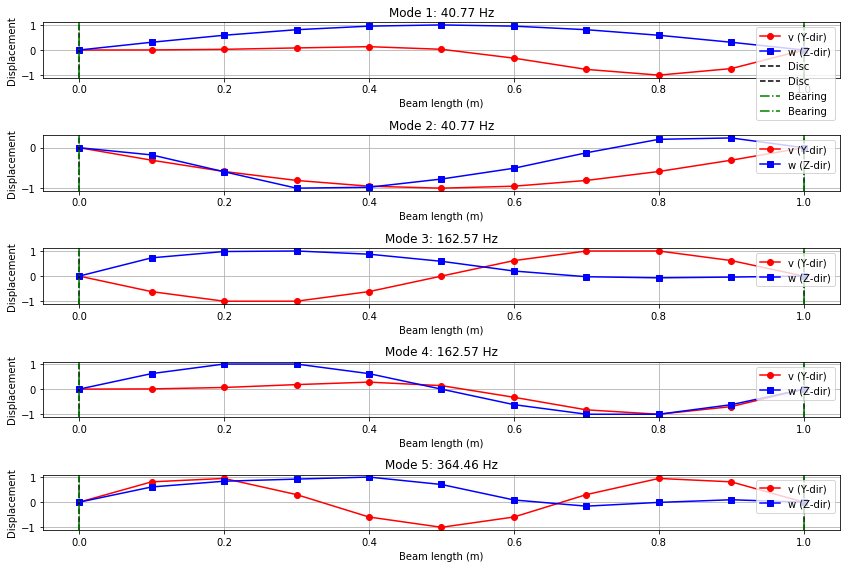

In [39]:
# === USER INPUT FOR BEAM AND MATERIAL PROPERTIES ===
print("\n=== Define the beam and material properties ===")
L = float(input("Total beam length [m]: "))
E = float(input("Young's modulus [Pa]: "))
rho = float(input("Density [kg/m^3]: "))
D  = float(input("Diameter of beam [m]: "))
I = float(input("Moment of inertia for circular cross-section [m^4]: "))
A = float(input("Cross-sectional area [m^2]: "))



# FEM discretization
n_elem = 10
n_nodes = n_elem + 1
dof_per_node = 4
total_dof = dof_per_node * n_nodes
dx = L / n_elem

def beam_3d_bending_matrices(E, I, rho, A, L):
    k2d = E * I / L**3 * np.array([
        [12, 6*L, -12, 6*L],
        [6*L, 4*L**2, -6*L, 2*L**2],
        [-12, -6*L, 12, -6*L],
        [6*L, 2*L**2, -6*L, 4*L**2]
    ])
    
    m2d = rho * A * L / 420 * np.array([
        [156, 22*L, 54, -13*L],
        [22*L, 4*L**2, 13*L, -3*L**2],
        [54, 13*L, 156, -22*L],
        [-13*L, -3*L**2, -22*L, 4*L**2]
    ])
    
    k = np.zeros((8, 8))
    m = np.zeros((8, 8))
    k[np.ix_([0,1,4,5],[0,1,4,5])] = k2d
    m[np.ix_([0,1,4,5],[0,1,4,5])] = m2d
    k[np.ix_([2,3,6,7],[2,3,6,7])] = k2d
    m[np.ix_([2,3,6,7],[2,3,6,7])] = m2d
    
    return k, m

# Assemble global matrices
K_global = np.zeros((total_dof, total_dof))
M_global = np.zeros((total_dof, total_dof))

for e in range(n_elem):
    k_e, m_e = beam_3d_bending_matrices(E, I, rho, A, dx)
    dof_map = [4*e + i for i in range(8)]
    for i in range(8):
        for j in range(8):
            K_global[dof_map[i], dof_map[j]] += k_e[i, j]
            M_global[dof_map[i], dof_map[j]] += m_e[i, j]
            

#=============================================================================================================================
# === USER INPUT FOR 2 DISCS ===
print("\n=== Define 2 Rigid Discs ===")
disc1_pos = float(input("Disc 1 position [m]: "))   # [m] position along beam
disc1_diam = float(input("Disc 1 diameter [m]: "))   # [m] diameter of rigid disc
disc1_thick = float(input("Disc 1 thickness [m]: "))   # [m] axial thickness
disc1_density = float(input("Disc 1 density [kg/m^3]: "))   # [kg/m³] (same as beam material)

disc2_pos = float(input("Disc 2 position [m]: "))
disc2_diam = float(input("Disc 2 diameter [m]: "))
disc2_thick = float(input("Disc 2 thickness [m]: "))
disc2_density = float(input("Disc 2 density [kg/m^3]: "))


# === Add Discs ===
# Store all disc properties in a list of dictionaries
discs = [
    {'pos': disc1_pos, 'diameter': disc1_diam, 'thickness': disc1_thick, 'density': disc1_density},
    {'pos': disc2_pos, 'diameter': disc2_diam, 'thickness': disc2_thick, 'density': disc2_density}
]

# === ADD DISCS TO GLOBAL MASS MATRIX ===
for disc in discs:
    r = disc['diameter'] / 2
    m = disc['density'] * np.pi * r**2 * disc['thickness']  # Mass of the disc
    J = 0.5 * m * r**2  # Rotational inertia (polar moment) approximation

    # Map position to nearest node
    node = int(round(disc['pos'] / dx))
    node = np.clip(node, 0, n_nodes - 1)  # Ensure within bounds

    dof_v = 4 * node   # v (Y translation)
    dof_theta_z = dof_v + 1  # θz (rotation about Z)
    dof_w = dof_v + 2   # w (Z translation)
    dof_theta_y = dof_v + 3 # θy (rotation about Y)

    # Add disc mass to translational DOFs
    M_global[dof_v, dof_v] += m
    M_global[dof_w, dof_w] += m
    
    # Add disc rotational inertia to rotational DOFs
    M_global[dof_theta_y, dof_theta_y] += J
    M_global[dof_theta_z, dof_theta_z] += J


# === USER INPUT FOR FLEXIBLE BEARINGS ===
print("\n=== Define 2 Bearings ===")
bear1_pos = float(input("Bearing 1 position [m]: "))   # [m] position along beam
bear1_k = float(input("Bearing 1 translational stiffness [N/m]: ")) # [N/m] translational stiffness (flexibility of the bearing)
bear1_kr = float(input("Bearing 1 rotational stiffness [Nm/rad]: ")) # [Nm/rad] rotational stiffness of bearing (optional)

bear2_pos = float(input("Bearing 2 position [m]: "))
bear2_k = float(input("Bearing 2 translational stiffness [N/m]: "))
bear2_kr = float(input("Bearing 2 rotational stiffness [Nm/rad]: "))


# === Add Bearings ===
# Store bearing properties
bearings = [
    {'pos': bear1_pos, 'k': bear1_k, 'kr': bear1_kr},
    {'pos': bear2_pos, 'k': bear2_k, 'kr': bear2_kr}
]

# === ADD BEARING STIFFNESS TO GLOBAL STIFFNESS MATRIX ===
for b in bearings:
    node = int(round(b['pos'] / dx))
    node = np.clip(node, 0, n_nodes - 1)

    dof_v = 4 * node   # v (Y direction)
    dof_theta_z = dof_v + 1   # θz (about Z)
    dof_w = dof_v + 2    # w (Z direction)
    dof_theta_y = dof_v + 3   # θy (about Y)

    # Add translational stiffness
    K_global[dof_v, dof_v] += b['k']
    K_global[dof_w, dof_w] += b['k']
    
    # Add rotational stiffness
    K_global[dof_theta_y, dof_theta_y] += b['kr']
    K_global[dof_theta_z, dof_theta_z] += b['kr']

    
#=============================================================================================================================  
    
    
# === Boundary Conditions ===
constrained_dofs = [0, 2, total_dof - 4, total_dof - 2]
free_dofs = np.setdiff1d(np.arange(total_dof), constrained_dofs)

K_reduced = K_global[np.ix_(free_dofs, free_dofs)]
M_reduced = M_global[np.ix_(free_dofs, free_dofs)]

eigvals, eigvecs = eigh(K_reduced, M_reduced)
frequencies = np.sqrt(eigvals) / (2 * np.pi)




# Print natural frequencies
print("Natural Frequencies (Hz):")
for i, f in enumerate(frequencies[:n_modes]):
    print(f"Mode {i+1}: {f:.2f} Hz")

# === Plot Mode Shapes ===
n_modes = 5
x = np.linspace(0, L, n_nodes)

fig = plt.figure(figsize=(12, 8))
for i in range(n_modes):
    full_mode = np.zeros(total_dof)
    full_mode[free_dofs] = eigvecs[:, i]
    
    v = full_mode[0::4]
    w = full_mode[2::4]
    v /= np.max(np.abs(v))
    w /= np.max(np.abs(w))
    
    ax = fig.add_subplot(n_modes, 1, i+1)
            # Plot mode shapes
    plt.plot(x, v, 'r-o', label='v (Y-dir)')
    plt.plot(x, w, 'b-s', label='w (Z-dir)')
    
#================================================================================================================
    # === Mark disc positions ===
    for disc in discs:
        disc_node = int(round(disc['pos'] / dx))
        disc_x = disc_node * dx
        plt.axvline(x=disc_x, color='k', linestyle='--', label='Disc' if i == 0 else "")
    
    # === Mark bearing positions ===
    for b in bearings:
        bear_node = int(round(b['pos'] / dx))
        bear_x = bear_node * dx
        plt.axvline(x=bear_x, color='g', linestyle='-.', label='Bearing' if i == 0 else "")
#================================================================================================================
    plt.title(f"Mode {i+1}: {frequencies[i]:.2f} Hz")
    plt.xlabel("Beam length (m)")
    plt.ylabel("Displacement")
    plt.legend(loc='upper right')
    plt.grid(True)

plt.tight_layout()
plt.show()

# 3D rigid discs corrected


=== Define 2 Rigid Discs ===
Disc 1 position [m]: 0.3
Disc 1 diameter [m]: 0.05
Disc 1 thickness [m]: 0.02
Disc 1 density [kg/m^3]: 7800
Disc 2 position [m]: 0.7
Disc 2 diameter [m]: 0.05
Disc 2 thickness [m]: 0.02
Disc 2 density [kg/m^3]: 7800

=== Define 2 Bearings ===
Bearing 1 position [m]: 0
Bearing 1 translational stiffness [N/m]: 10
Bearing 1 rotational stiffness [Nm/rad]: 10
Bearing 2 position [m]: 1
Bearing 2 translational stiffness [N/m]: 10
Bearing 2 rotational stiffness [Nm/rad]: 10
Natural frequencies (Y plane):
w_y_1: 40.75 Hz
w_y_2: 163.03 Hz
w_y_3: 366.97 Hz
w_y_4: 653.12 Hz
w_y_5: 1022.83 Hz
w_y_6: 1478.73 Hz

Natural frequencies (Z plane):
w_z_1: 40.75 Hz
w_z_2: 163.03 Hz
w_z_3: 366.97 Hz
w_z_4: 653.12 Hz
w_z_5: 1022.83 Hz
w_z_6: 1478.73 Hz


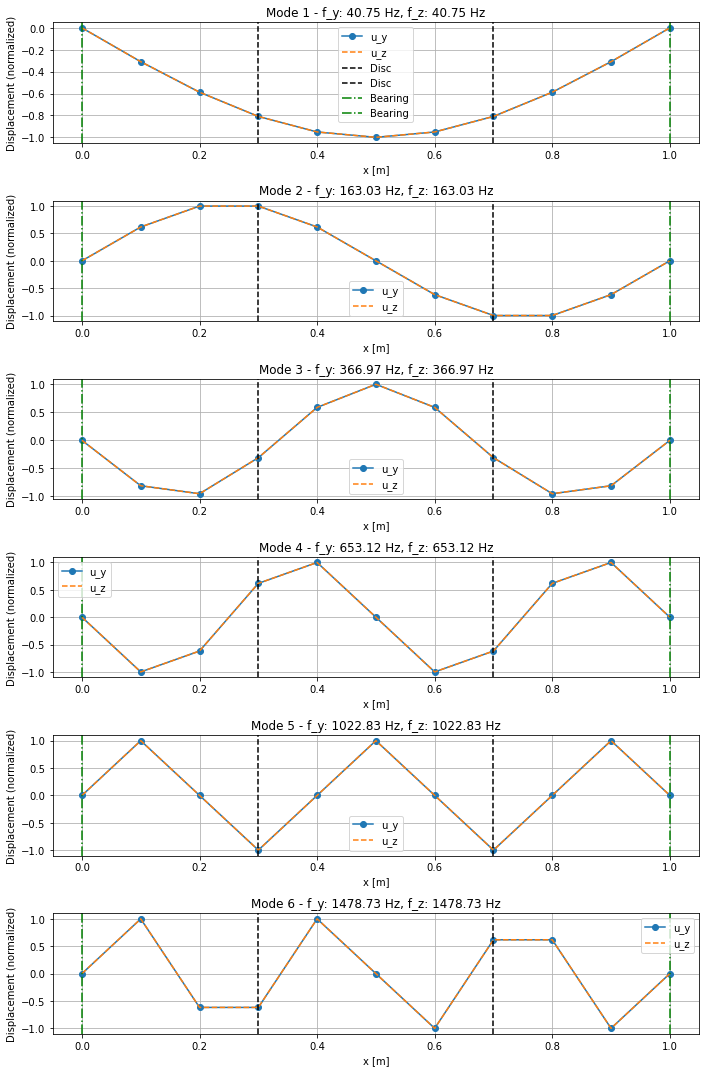

In [17]:
# === USER INPUT FOR BEAM AND MATERIAL PROPERTIES ===
print("\n=== Define the beam and material properties ===")
L = float(input("Total beam length [m]: "))
E = float(input("Young's modulus [Pa]: "))
rho = float(input("Density [kg/m^3]: "))
D  = float(input("Diameter of beam [m]: "))
I = (np.pi * D**4) / 64     # Moment of inertia [m^4]
A = (np.pi * D**2) / 4      # Cross-sectional area [m^2]

# === FEM discretization ===
n_elem = 10
n_nodes = n_elem + 1
dof_per_node = 2  # per plane: [u, theta]
total_dof = dof_per_node * n_nodes
dx = L / n_elem

# === Element stiffness and mass matrices (4x4 for each plane) ===
def beam_element_matrices(E, I, rho, A, L):
    K_local = (E * I / L**3) * np.array([
        [12, 6*L, -12, 6*L],
        [6*L, 4*L**2, -6*L, 2*L**2],
        [-12, -6*L, 12, -6*L],
        [6*L, 2*L**2, -6*L, 4*L**2]
    ])
    
    M_local = (rho * A * L / 420) * np.array([
        [156, 22*L, 54, -13*L],
        [22*L, 4*L**2, 13*L, -3*L**2],
        [54, 13*L, 156, -22*L],
        [-13*L, -3*L**2, -22*L, 4*L**2]
    ])
    
    return K_local, M_local

# === Initialize global matrices for Y and Z planes ===
K_global_y = np.zeros((total_dof, total_dof))
M_global_y = np.zeros((total_dof, total_dof))

K_global_z = np.zeros((total_dof, total_dof))
M_global_z = np.zeros((total_dof, total_dof))

# === Assembly ===
K_local, M_local = beam_element_matrices(E, I, rho, A, dx)

for e in range(n_elem):
    dof_map = [2*e, 2*e+1, 2*e+2, 2*e+3]
    
    for i in range(4):
        for j in range(4):
            K_global_y[dof_map[i], dof_map[j]] += K_local[i, j]
            M_global_y[dof_map[i], dof_map[j]] += M_local[i, j]
            K_global_z[dof_map[i], dof_map[j]] += K_local[i, j]
            M_global_z[dof_map[i], dof_map[j]] += M_local[i, j]
            
            
            
            
#=============================================================================================================================
# === USER INPUT FOR 2 DISCS ===
print("\n=== Define 2 Rigid Discs ===")
disc1_pos = float(input("Disc 1 position [m]: "))   # [m] position along beam
disc1_diam = float(input("Disc 1 diameter [m]: "))   # [m] diameter of rigid disc
disc1_thick = float(input("Disc 1 thickness [m]: "))   # [m] axial thickness
disc1_density = float(input("Disc 1 density [kg/m^3]: "))   # [kg/m³] (same as beam material)

disc2_pos = float(input("Disc 2 position [m]: "))
disc2_diam = float(input("Disc 2 diameter [m]: "))
disc2_thick = float(input("Disc 2 thickness [m]: "))
disc2_density = float(input("Disc 2 density [kg/m^3]: "))


# === Add Discs ===
# Store all disc properties in a list of dictionaries
discs = [
    {'pos': disc1_pos, 'diameter': disc1_diam, 'thickness': disc1_thick, 'density': disc1_density},
    {'pos': disc2_pos, 'diameter': disc2_diam, 'thickness': disc2_thick, 'density': disc2_density}
]

# === ADD DISCS TO GLOBAL MASS MATRIX ===
for disc in discs:
    r = disc['diameter'] / 2
    m = disc['density'] * np.pi * r**2 * disc['thickness']  # Mass of the disc
    J = 0.5 * m * r**2  # Rotational inertia (polar moment) approximation

    # Map position to nearest node
    node = int(round(disc['pos'] / dx))
    node = np.clip(node, 0, n_nodes - 1)  # Ensure within bounds

    dof_v = 4 * node   # v (Y translation)
    dof_theta_z = dof_v + 1  # θz (rotation about Z)
    dof_w = dof_v + 2   # w (Z translation)
    dof_theta_y = dof_v + 3 # θy (rotation about Y)

    # Add disc mass to translational DOFs
    M_global[dof_v, dof_v] += m
    M_global[dof_w, dof_w] += m
    
    # Add disc rotational inertia to rotational DOFs
    M_global[dof_theta_y, dof_theta_y] += J
    M_global[dof_theta_z, dof_theta_z] += J


# === USER INPUT FOR FLEXIBLE BEARINGS ===
print("\n=== Define 2 Bearings ===")
bear1_pos = float(input("Bearing 1 position [m]: "))   # [m] position along beam
bear1_k = float(input("Bearing 1 translational stiffness [N/m]: ")) # [N/m] translational stiffness (flexibility of the bearing)
bear1_kr = float(input("Bearing 1 rotational stiffness [Nm/rad]: ")) # [Nm/rad] rotational stiffness of bearing (optional)

bear2_pos = float(input("Bearing 2 position [m]: "))
bear2_k = float(input("Bearing 2 translational stiffness [N/m]: "))
bear2_kr = float(input("Bearing 2 rotational stiffness [Nm/rad]: "))


# === Add Bearings ===
# Store bearing properties
bearings = [
    {'pos': bear1_pos, 'k': bear1_k, 'kr': bear1_kr},
    {'pos': bear2_pos, 'k': bear2_k, 'kr': bear2_kr}
]

# === ADD BEARING STIFFNESS TO GLOBAL STIFFNESS MATRIX ===
for b in bearings:
    node = int(round(b['pos'] / dx))
    node = np.clip(node, 0, n_nodes - 1)

    dof_v = 4 * node   # v (Y direction)
    dof_theta_z = dof_v + 1   # θz (about Z)
    dof_w = dof_v + 2    # w (Z direction)
    dof_theta_y = dof_v + 3   # θy (about Y)

    # Add translational stiffness
    K_global[dof_v, dof_v] += b['k']
    K_global[dof_w, dof_w] += b['k']
    
    # Add rotational stiffness
    K_global[dof_theta_y, dof_theta_y] += b['kr']
    K_global[dof_theta_z, dof_theta_z] += b['kr']

    
#=============================================================================================================================  
    

# === Boundary conditions (simply supported at both ends) ===
# Fix displacement DOF at node 0 and last node
constrained_dofs = [0, dof_per_node*(n_nodes-1)]

free_dofs = np.setdiff1d(np.arange(total_dof), constrained_dofs)

# === Reduce matrices ===
K_reduced_y = K_global_y[np.ix_(free_dofs, free_dofs)]
M_reduced_y = M_global_y[np.ix_(free_dofs, free_dofs)]

K_reduced_z = K_global_z[np.ix_(free_dofs, free_dofs)]
M_reduced_z = M_global_z[np.ix_(free_dofs, free_dofs)]

# === Solve eigenvalue problem for Y and Z planes ===
eigvals_y, eigvecs_y = eigh(K_reduced_y, M_reduced_y)
eigvals_z, eigvecs_z = eigh(K_reduced_z, M_reduced_z)

freqs_y = np.sqrt(eigvals_y) / (2 * np.pi)
freqs_z = np.sqrt(eigvals_z) / (2 * np.pi)

# === Print frequencies ===
print("Natural frequencies (Y plane):")
for i, f in enumerate(freqs_y[:6]):
    print(f"w_y_{i+1}: {f:.2f} Hz")

print("\nNatural frequencies (Z plane):")
for i, f in enumerate(freqs_z[:6]):
    print(f"w_z_{i+1}: {f:.2f} Hz")

# === Plot mode shapes ===
x = np.linspace(0, L, n_nodes)
n_modes = min(6, len(freqs_y))

plt.figure(figsize=(10, 2.5 * n_modes))

for i in range(n_modes):
    # reconstruct full mode shape
    mode_y = np.zeros(total_dof)
    mode_z = np.zeros(total_dof)
    mode_y[free_dofs] = eigvecs_y[:, i]
    mode_z[free_dofs] = eigvecs_z[:, i]
    
    w_y = mode_y[::dof_per_node]
    w_z = mode_z[::dof_per_node]
    
    w_y /= np.max(np.abs(w_y))
    w_z /= np.max(np.abs(w_z))
    
    plt.subplot(n_modes, 1, i+1)
    plt.plot(x, w_y, '-o', label='u_y')
    plt.plot(x, w_z, '--', label='u_z')
    
    #================================================================================================================
    # === Mark disc positions ===
    for disc in discs:
        disc_node = int(round(disc['pos'] / dx))
        disc_x = disc_node * dx
        plt.axvline(x=disc_x, color='k', linestyle='--', label='Disc' if i == 0 else "")
    
    # === Mark bearing positions ===
    for b in bearings:
        bear_node = int(round(b['pos'] / dx))
        bear_x = bear_node * dx
        plt.axvline(x=bear_x, color='g', linestyle='-.', label='Bearing' if i == 0 else "")
#================================================================================================================
    
    
    plt.title(f"Mode {i+1} - f_y: {freqs_y[i]:.2f} Hz, f_z: {freqs_z[i]:.2f} Hz")
    plt.xlabel("x [m]")
    plt.ylabel("Displacement (normalized)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# Example : 

In [24]:
(np.pi * D**4) / 64  #I

7.853981633974483e-09

In [27]:
(np.pi * D**2) / 4  #A

0.0003141592653589793